In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt

In [3]:
DATA_PATH = "/mnt/data1/romualdo_data/datasets/air-quality/processed/global"
DATA_NAME = "data_cleaned_cycle_h_rbf_w8s1.csv"
PLOT_PATH = os.path.join("../../plots/notebooks/train_baselines", DATA_NAME.replace(".csv", ""))
MODEL_PATH = os.path.join("../../models", DATA_NAME.replace(".csv", ""))
RESULT_PATH = os.path.join("../../results", DATA_NAME.replace(".csv", ""))
TRAIN_RATIO = 0.8
TARGET_VARS = ["pm10","pm25","no2","co","c6h6","nox","bc","so2","nh3","o3"]
SEED = 42
PATHS = [MODEL_PATH, PLOT_PATH, RESULT_PATH]


In [4]:
for p in PATHS: 
    if not os.path.exists(p):
        os.makedirs(p)

In [5]:
def smape_score(y_true, y_pred):
    """Computes the symmetric Mean Absolute Percentage Error on the given numpy arrays.
    :param y_true:  list of actual values
    :type y_true:   numpy array of size (N,)
    :param y_pred:  list of predicted values
    :type y_pred:   numpy array of size (N,)
    :return:        symmetric MAPE, scaled bwtween 0 (no error) and 1 (absolute chaos)
    :rtype:         float64
    """
    return np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))


def mae_score(y_true, y_pred):
    """Computes the mean absolute error over the given arrays.
    :param y_true:  list of actual values
    :type y_true:   numpy array of size (N,)
    :param y_pred:  list of predicted values
    :type y_pred:   numpy array of size (N,)
    :return:        mean absolute error (mean of absolute differences between the values)
    :rtype:         float64
    """
    return np.mean(np.abs(y_true - y_pred))


def rmse_score(y_true, y_pred):
    """Computes the root mean squared error on the given data.

    :param y_true:  list of actual values
    :type y_true:   numpy array of size (N,)
    :param y_pred:  list of predicted values
    :type y_pred:   numpy array of size (N,)
    :return:        root mean squared error
    :rtype:         float64
    """
    return np.sqrt(mean_squared_error(y_true, y_pred))


def decay_weights(x, rate):
    x = x / float(np.max(x))
    return np.exp(-x * rate)[::-1]

In [6]:
data = pd.read_csv(os.path.join(DATA_PATH, DATA_NAME), index_col=0, parse_dates=True, date_parser=lambda x: pd.to_datetime(x))
data.dropna(inplace=True)
assert data.isna().sum().sum() == 0
data

temp  humidity  wind_speed  rain  radiation  \
2013-01-01 07:00:00   0.450000     92.68        0.40   0.0       0.55   
2013-01-01 08:00:00   0.216667     90.78        0.20   0.0       1.25   
2013-01-01 09:00:00   0.650000     89.98        0.60   0.0      31.45   
2013-01-01 10:00:00   1.600000     86.94        0.50   0.0     126.95   
2013-01-01 11:00:00   3.350000     82.54        0.40   0.0     225.90   
...                        ...       ...         ...   ...        ...   
2015-10-23 20:00:00  12.166667     68.88        0.40   0.0       0.00   
2015-10-23 21:00:00  11.633333     72.34        0.36   0.0       0.00   
2015-10-23 22:00:00  11.133333     75.50        0.40   0.0       0.00   
2015-10-23 23:00:00  10.683333     79.08        0.52   0.0       0.00   
2015-10-24 00:00:00  10.266667     81.54        0.52   0.0       0.00   

                     pressure       pm10       pm25       no2     co  ...  \
2013-01-01 07:00:00     999.6  37.607020  37.824401   63.6000  2.650  ...   
2013-01-01 08:00:00     999.6  57.543041  57.875660   65.1500  2.775  ...   
2013-01-01 09:00:00     999.6  75.486495  75.922833   68.6625  2.975  ...   
2013-01-01 10:00:00    1000.0  83.603154  84.086409   74.8625  3.125  ...   
2013-01-01 11:00:00    1000.1  86.609520  87.110153   86.8250  3.175  ...   
...                       ...        ...        ...       ...    ...  ...   
2015-10-23 20:00:00    1005.9  84.321138  65.421573  109.4375  2.550  ...   
2015-10-23 21:00:00    1006.4  76.616040  59.443479  112.7500  2.575  ...   
2015-10-23 22:00:00    1007.0  62.520383  48.507194  117.0125  2.625  ...   
2015-10-23 23:00:00    1007.4  70.260192  55.253597  121.2750  2.800  ...   
2015-10-24 00:00:00    1007.5  78.000000  62.000000  105.5500  2.625  ...   

                          rbf_03-7       rbf_04-7       rbf_05-7  \
2013-01-01 07:00:00   3.532629e-24   1.082112e-46   1.037140e-76   
2013-01-01 08:00:00   3.751012e-24   1.176916e-46   1.155404e-76   
2013-01-01 09:00:00   3.982762e-24   1.279984e-46   1.287111e-76   
2013-01-01 10:00:00   4.228690e-24   1.392032e-46   1.433784e-76   
2013-01-01 11:00:00   4.489654e-24   1.513837e-46   1.597117e-76   
...                            ...            ...            ...   
2015-10-23 20:00:00  1.638788e-203  4.280704e-152  3.498637e-108   
2015-10-23 21:00:00  1.373699e-203  3.675420e-152  3.076902e-108   
2015-10-23 22:00:00  1.151452e-203  3.155617e-152  2.705915e-108   
2015-10-23 23:00:00  9.651297e-204  2.709238e-152  2.379579e-108   
2015-10-24 00:00:00  8.089301e-204  2.325924e-152  2.092529e-108   

                          rbf_06-7       rbf_07-7       rbf_08-7  \
2013-01-01 07:00:00  3.110242e-114  2.918383e-159  8.568046e-212   
2013-01-01 08:00:00  3.549064e-114  3.411026e-159  1.025764e-211   
2013-01-01 09:00:00  4.049664e-114  3.986697e-159  1.228001e-211   
2013-01-01 10:00:00  4.620720e-114  4.659368e-159  1.470062e-211   
2013-01-01 11:00:00  5.272127e-114  5.445356e-159  1.759779e-211   
...                            ...            ...            ...   
2015-10-23 20:00:00   8.946926e-72   7.158800e-43   1.792247e-21   
2015-10-23 21:00:00   8.059569e-72   6.605432e-43   1.693878e-21   
2015-10-23 22:00:00   7.259977e-72   6.094636e-43   1.600854e-21   
2015-10-23 23:00:00   6.539496e-72   5.623152e-43   1.512888e-21   
2015-10-24 00:00:00   5.890318e-72   5.187969e-43   1.429708e-21   

                          rbf_09-7  rbf_10-7  rbf_11-7      rbf_12-7  
2013-01-01 07:00:00  7.870687e-272  0.000000  0.000000  0.000000e+00  
2013-01-01 08:00:00  9.651648e-272  0.000000  0.000000  0.000000e+00  
2013-01-01 09:00:00  1.183521e-271  0.000000  0.000000  0.000000e+00  
2013-01-01 10:00:00  1.451228e-271  0.000000  0.000000  0.000000e+00  
2013-01-01 11:00:00  1.779431e-271  0.000000  0.000000  0.000000e+00  
...                            ...       ...       ...           ...  
2015-10-23 20:00:00   1.403935e-07  0.344102  0.026389  6.332020e-11  
2015-10-23 21:00:00   

In [7]:
split = int(np.floor(len(data) * TRAIN_RATIO))
X_features = [f for f in data.columns if f not in TARGET_VARS]
Y_features = [f for f in data.columns if f in TARGET_VARS]

train_data, test_data = data.iloc[:split], data.iloc[split:]
X_train_df, Y_train_df = train_data[X_features], train_data[Y_features]
X_test_df, Y_test_df = test_data[X_features], test_data[Y_features]
print(X_train_df.shape, X_test_df.shape, Y_train_df.shape, Y_test_df.shape)

(19694, 312) (4924, 312) (19694, 10) (4924, 10)


In [8]:
from sklearn.linear_model import LinearRegression, BayesianRidge, HuberRegressor
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from joblib import dump, load

In [9]:
from sklearn.metrics import r2_score


def rmse_score(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

metrics = [mae_score, rmse_score, r2_score, smape_score]

In [10]:
    scaler = StandardScaler().fit(X_train_df)
    transformer = FunctionTransformer(func=np.log1p, inverse_func=np.expm1)
    X_train = scaler.transform(X_train_df)
    X_test = scaler.transform(X_test_df)
    Y_train, Y_test = Y_train_df.values, Y_test_df.values

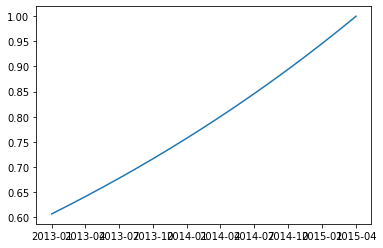

In [11]:
weights = decay_weights(np.arange(len(X_train)), 0.5)
plt.plot(X_train_df.index, weights)

In [12]:
# for each output
weights = decay_weights(np.arange(len(X_train)), 0.5)
feature_names = Y_train_df.columns
results = []

for i in range(Y_train.shape[1]):
    feature = feature_names[i]
    #model definition inside for reinitialization 
    models = {
        "LinReg": LinearRegression(), 
        "BRidge": BayesianRidge(n_iter=1000, tol=1e-4),
        "HuberR": HuberRegressor(max_iter=1000),
        "LinSVR": LinearSVR(tol=1e-4, C=0.9, random_state=SEED),
        "RF-n200-d6": RandomForestRegressor(n_estimators=200, n_jobs=4, max_depth=6, random_state=SEED,),
        "AB-n200-d6": AdaBoostRegressor(DecisionTreeRegressor(max_depth=6), n_estimators=200, random_state=SEED)
    }
    print("-"*20)
    print(f"fitting on {feature}...")
    print("-"*20)
    for m_name, model in models.items():
        y_true = Y_test[:,i]
        reg = model.fit(X_train, transformer.transform(Y_train[:,i].reshape(-1, 1)), sample_weight=weights)
        y_pred = reg.predict(X_test).reshape(-1, 1)
        y_pred = transformer.inverse_transform(y_pred).flatten()

        model_path = ""
        model_path = os.path.join(MODEL_PATH, feature)
        if not os.path.exists(model_path):
            os.makedirs(model_path)
        model_path = os.path.join(model_path,  f"{m_name}.jlib")
        dump(reg, model_path)

        f = plt.figure(figsize=(50, 6))
        plt.plot(Y_test_df.index, y_true, 'g--')
        plt.plot(Y_test_df.index, y_pred, 'r-')
        plt.title(f"{type(model).__name__}")
        plt.tight_layout()
        plot_name = f"{feature}_{m_name}.png"
        plt.savefig(os.path.join(PLOT_PATH, plot_name))
        plt.close(f)

        scores = [f(y_true, y_pred) for f in metrics]
        for m, score in zip(metrics, scores):
            metric_name = m.__name__
            name = f"{m_name} - {metric_name}"
            print(f"{name:<40s}: {score:04.4f}")
            results.append([feature, m_name, metric_name, score])
        print("-"*20)

results_df = pd.DataFrame(results, columns=["feature", "model", "metric", "score"])    


--------------------
fitting on pm10...
--------------------
LinReg - mae_score                      : 11.2189
LinReg - rmse_score                     : 16.4242
LinReg - r2_score                       : -0.1131
LinReg - smape_score                    : 0.1919
--------------------
BRidge - mae_score                      : 9.0111
BRidge - rmse_score                     : 12.9191
BRidge - r2_score                       : 0.3113
BRidge - smape_score                    : 0.1619
--------------------
HuberR - mae_score                      : 8.8590
HuberR - rmse_score                     : 12.6179
HuberR - r2_score                       : 0.3430
HuberR - smape_score                    : 0.1590
--------------------
LinSVR - mae_score                      : 8.3493
LinSVR - rmse_score                     : 11.5056
LinSVR - r2_score                       : 0.4538
LinSVR - smape_score                    : 0.1632
--------------------
RF-n200-d6 - mae_score                  : 9.7444
RF-n200-d6 - rms

In [13]:
results_df.to_csv(os.path.join(RESULT_PATH, "run01.csv"), index=False)